### Závěrečný projekt - modul Python

Analýza dat získaných z  `www.sreality.cz` se zaměřením na pronájmy bytů ve městě Zlín
 

WebScraping

In [ ]:
from bs4 import BeautifulSoup
import requests
import time
import re
import pandas as pd
from urllib.parse import urljoin

# --- Nastavení ---
BASE = "https://www.sreality.cz"
START_URL = "https://www.sreality.cz/hledani/pronajem/byty/zlin"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"
}

# dispozice
def get_detail_info(url: str):
    try:
        r = requests.get(url, headers=HEADERS, timeout=30)
        if r.status_code != 200:
            return None, None

        soup = BeautifulSoup(r.text, "html.parser")

       
        text = soup.get_text(" ", strip=True)
        dispo = None
        t = text.lower().replace(" ", "")
        moznosti = ["1+kk","1+1","2+kk","2+1","3+kk","3+1","4+kk","4+1","5+kk","5+1"]
        for d in moznosti:
            if d in t:
                dispo = d
                break

        # lokace
               og = soup.find("meta", property="og:title")
        title = og["content"].strip() if og and og.get("content") else (soup.title.text.strip() if soup.title else "")

        lokace = None
        m = re.search(r"m²\s*(.+)$", title)
        if m:
            lokace = m.group(1).strip()

        # první výskyt
        if not lokace:
            m2 = re.search(r"([A-Za-zÁ-Žá-ž0-9\s\.\-]+,\s*(Zlín|Otrokovice|Malenovice|Příluky)[^\n\r]*)", text)
            if m2:
                lokace = m2.group(1).strip()

        return dispo, lokace

    except Exception:
        return None, None

# ---  Scrap jedné stránky výsledků ---
def scrape_one_page(page: int):
    """
    Vrátí seznam inzerátů ze stránky page.
    URL bere z /detail/ odkazů na list page.
    Cena, m², lokace bere z kontejneru okolo odkazu (list page).
    Dispozice bere z detailu (hlavní oprava).
    """
    url = f"{START_URL}?strana={page}"
    r = requests.get(url, headers=HEADERS, timeout=30)

    # Sreality někdy po konci stránek vrací 404 -> znamená konec stránkování
    if r.status_code == 404:
        return []

    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    # odkazy na detail
    a_tags = soup.find_all("a", href=True)
    detail_hrefs = [a["href"] for a in a_tags if "/detail/" in a["href"]]

    # unikátní (zachová pořadí)
    detail_hrefs = list(dict.fromkeys(detail_hrefs))

    results = []
    for href in detail_hrefs:
        full_url = urljoin(BASE, href)

        # najdeme konkrétní <a> tag s tímto href, a vezmeme text z jeho "kontejneru"
        link_tag = soup.find("a", href=href)
        if not link_tag:
            continue

        container = link_tag
        # zkusíme jít pár úrovní výš a sebrat text karty
        for _ in range(4):
            if container.parent:
                container = container.parent

        text = container.get_text(" ", strip=True)

        # m² z list page
        m2 = None
        m = re.search(r"(\d+[.,]?\d*)\s*m²", text)
        if m:
            m2 = m.group(1).replace(",", ".")

        # cena z list page
        price = None
        m = re.search(r"(\d[\d\s\xa0]+)\s*Kč", text)
        if m:
            price = m.group(1).replace("\xa0", " ").strip()

        
        
        dispozice, location = get_detail_info(full_url)
        time.sleep(0.5)  # zpomalení

        results.append({
            "url": full_url,
            "rozmera_m2": m2,
            "dispozice": dispozice,
            "cena_kc": price,
            "lokace": location
        })

    return results

# ---  Pagination přes všechny stránky ---
all_rows = []
seen_urls = set()

page = 1
while True:
    print(f"Stránka {page}...")
    rows = scrape_one_page(page)
    print("  nalezeno:", len(rows))

    if len(rows) == 0:
        break

    new_count = 0
    for row in rows:
        if row["url"] not in seen_urls:
            all_rows.append(row)
            seen_urls.add(row["url"])
            new_count += 1

    print("  nových přidáno:", new_count)

    if new_count == 0:
        break

    page += 1
    time.sleep(1)  # pauza mezi stránkami

# --- DataFrame + uložení surových dat ---
df_raw = pd.DataFrame(all_rows).drop_duplicates(subset=["url"])
print("Výsledný tvar:", df_raw.shape)

# kontrola dispozic
print(df_raw["dispozice"].value_counts(dropna=False).head(20))

# Uložení podle zadání
df_raw.to_csv("Brozova_Milena_surova_data.csv", index=False, encoding="utf-8-sig")
print("Uloženo: Brozova_Milena_surova_data.csv")

Stránka 1...
  nalezeno: 21
  nových přidáno: 21
Stránka 2...
  nalezeno: 21
  nových přidáno: 21
Stránka 3...
  nalezeno: 21
  nových přidáno: 21
Stránka 4...
  nalezeno: 21
  nových přidáno: 20
Stránka 5...
  nalezeno: 20
  nových přidáno: 19
Stránka 6...
  nalezeno: 21
  nových přidáno: 20
Stránka 7...
  nalezeno: 21
  nových přidáno: 19
Stránka 8...
  nalezeno: 21
  nových přidáno: 20
Stránka 9...
  nalezeno: 21
  nových přidáno: 21
Stránka 10...
  nalezeno: 21
  nových přidáno: 18
Stránka 11...
  nalezeno: 17
  nových přidáno: 16
Stránka 12...
  nalezeno: 0
Výsledný tvar: (216, 5)
dispozice
1+kk    49
2+kk    43
2+1     37
1+1     29
3+kk    26
3+1     22
None     4
4+1      4
5+kk     1
4+kk     1
Name: count, dtype: int64
Uloženo: Brozova_Milena_surova_data.csv


Proces ETL

1.  EXTRACT - Načtení dat a základní informace

In [75]:
import pandas as pd

df_raw = pd.read_csv("Brozova_Milena_surova_data.csv")
print("Surová data:", df_raw.shape)
display(df_raw.head())
df_raw.info()

Surová data: (216, 5)


,url,rozmera_m2,dispozice,cena_kc,lokace
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+kk,12 900,", Devadesátá, Zlín"
1,https://www.sreality.cz/detail/pronajem/byt/2+...,35,2+1,12 900,", třída Tomáše Bati, Zlín"
2,https://www.sreality.cz/detail/pronajem/byt/2+...,35,2+1,12 900,", Dlouhá, Zlín"
3,https://www.sreality.cz/detail/pronajem/byt/2+...,35,2+1,12 900,", Nádražní, Otrokovice"
4,https://www.sreality.cz/detail/pronajem/byt/1+...,35,1+kk,12 900,", Nad Stráněmi, Zlín"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   url         216 non-null    object
 1   rozmera_m2  216 non-null    int64 
 2   dispozice   212 non-null    object
 3   cena_kc     216 non-null    object
 4   lokace      216 non-null    object
dtypes: int64(1), object(4)
memory usage: 8.6+ KB


In [78]:
df_raw.shape

(216, 5)

2. TRANSFORM 

= vyčištění textů, normalizace dispozice, oprava textu lokace(čárka před)

In [ ]:
df = df_raw.copy()

# oříznutí mezer u textových sloupců
for col in ["url", "dispozice", "cena_kc", "rozmera_m2", "lokace"]:
    df[col] = df[col].astype(str).str.strip()

# normalizace dispozic 
df["dispozice"] = (
    df["dispozice"]
    .replace("None", pd.NA)
    .str.lower()
    .str.replace(" ", "", regex=False)
)

# oprava lokace: odstranění úvodní čárky ","
df["lokace"] = (
    df["lokace"]
    .astype(str)
    .str.strip()
    .str.lstrip(",")
    .str.strip()
)

df[["dispozice", "lokace"]].head()

,dispozice,lokace
0,1+kk,"Devadesátá, Zlín"
1,2+1,"třída Tomáše Bati, Zlín"
2,2+1,"Dlouhá, Zlín"
3,2+1,"Nádražní, Otrokovice"
4,1+kk,"Nad Stráněmi, Zlín"


= převod datových typů

In [81]:
df["cena_kc"] = (
    df["cena_kc"]
    .astype(str)
    .str.replace(r"\D", "", regex=True)
    .replace("", pd.NA)
    .astype("Int64")
)

df["rozmera_m2"] = (
    df["rozmera_m2"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype("Float64")
)

df.dtypes

url            object
rozmera_m2    Float64
dispozice      object
cena_kc         Int64
lokace         object
dtype: object

= rozdělení lokace na ulici a město

In [82]:
parts = df["lokace"].str.split(",", n=1, expand=True)

df["ulice"] = parts[0].str.strip()
df["mesto"] = parts[1].fillna("").str.strip()

df[["lokace", "ulice", "mesto"]].head()

,lokace,ulice,mesto
0,"Devadesátá, Zlín",Devadesátá,Zlín
1,"třída Tomáše Bati, Zlín",třída Tomáše Bati,Zlín
2,"Dlouhá, Zlín",Dlouhá,Zlín
3,"Nádražní, Otrokovice",Nádražní,Otrokovice
4,"Nad Stráněmi, Zlín",Nad Stráněmi,Zlín


=ošetření NaN - nelze je analyzovat, proto je můžeme odstranit

In [ ]:
pred = df.shape[0]

# filtr jen na město Zlín (kvůli zadání)
df = df[df["mesto"].str.contains("Zlín", na=False)].copy()

# odstranění řádků s chybějícími hodnotami pro analýzu
df_clean = df.dropna(subset=["url", "dispozice", "cena_kc", "rozmera_m2", "mesto"]).copy()

po = df_clean.shape[0]
print("Před:", pred, "Po (Zlín + čištění):", po, "Odstraněno:", pred - po)

# dispozice jako kategorie
df_clean["dispozice"] = df_clean["dispozice"].astype("category")

print(f'Řádky bez ceny, rozměru, dispozice byly odstraněny, protože nejdou analyzovat.')
print(f'Kdybychom je ponechali, zkerslily by nám výpočty.')
print(f'Některé inzeráty byly mimo město Zlín, proto byla data omezena jen na Zlín.')


Před: 148 Po (Zlín + čištění): 148 Odstraněno: 0
Řádky bez ceny, rozměru, dispozice byly odstraněny, protože nejdou analyzovat.
Kdybychom je ponechali, zkerslily by nám výpočty.
Některé inzeráty byly mimo město Zlín, proto byla data omezena jen na Zlín.


3. LOAD 

= základní statistika o vyčištěných datech

In [91]:
print("Vyčištěná data:", df_clean.shape)
display(df_clean.head())

display(df_clean[["cena_kc", "rozmera_m2"]].describe())
display(df_clean["dispozice"].value_counts())

Vyčištěná data: (148, 7)


,url,rozmera_m2,dispozice,cena_kc,lokace,ulice,mesto
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35.0,1+kk,12900,"Devadesátá, Zlín",Devadesátá,Zlín
1,https://www.sreality.cz/detail/pronajem/byt/2+...,35.0,2+1,12900,"třída Tomáše Bati, Zlín",třída Tomáše Bati,Zlín
2,https://www.sreality.cz/detail/pronajem/byt/2+...,35.0,2+1,12900,"Dlouhá, Zlín",Dlouhá,Zlín
4,https://www.sreality.cz/detail/pronajem/byt/1+...,35.0,1+kk,12900,"Nad Stráněmi, Zlín",Nad Stráněmi,Zlín
5,https://www.sreality.cz/detail/pronajem/byt/3+...,35.0,3+1,12900,"Díly IV, Zlín",Díly IV,Zlín


,cena_kc,rozmera_m2
count,148.0,148.0
mean,13200.675676,39.932432
std,1989.547401,9.980704
min,11500.0,33.0
25%,11500.0,35.0
50%,12500.0,36.0
75%,13500.0,36.0
max,17000.0,60.0


dispozice
1+kk    35
2+kk    30
2+1     23
1+1     19
3+kk    19
3+1     18
4+1      3
5+kk     1
Name: count, dtype: int64

= export vyčištěných dat

In [96]:
df_clean.to_csv("Brozova_Milena_zdrojova_data.csv", index=False, encoding="utf-8-sig")
print("Uloženo: Brozova_Milena_zdrojova_data.csv")

Uloženo: Brozova_Milena_zdrojova_data.csv


Datová analýza

= načtení vyčištěných dat

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Brozova_Milena_zdrojova_data.csv")
df.head()


,url,rozmera_m2,dispozice,cena_kc,lokace,ulice,mesto
0,https://www.sreality.cz/detail/pronajem/byt/1+...,35.0,1+kk,12900,"Devadesátá, Zlín",Devadesátá,Zlín
1,https://www.sreality.cz/detail/pronajem/byt/2+...,35.0,2+1,12900,"třída Tomáše Bati, Zlín",třída Tomáše Bati,Zlín
2,https://www.sreality.cz/detail/pronajem/byt/2+...,35.0,2+1,12900,"Dlouhá, Zlín",Dlouhá,Zlín
3,https://www.sreality.cz/detail/pronajem/byt/1+...,35.0,1+kk,12900,"Nad Stráněmi, Zlín",Nad Stráněmi,Zlín
4,https://www.sreality.cz/detail/pronajem/byt/3+...,35.0,3+1,12900,"Díly IV, Zlín",Díly IV,Zlín


= průměrná a mediánová cena bytů

In [99]:
prumer = df["cena_kc"].mean()
median = df["cena_kc"].median()

prumer_text = f"{round(prumer):,} Kč".replace(",", " ")
median_text = f"{round(median):,} Kč".replace(",", " ")

prumer_text, median_text

print(f' Průměrná cena pronájmu bytů ve Zlíně je {prumer_text}, mediánová cena dosahuje hodnoty {median_text}.')
print(f'Mediánová cena je nižší než průměrná cena')
print(f'Průměrná cena je zvyšována přítomností nabídky pronájmu dražších bytů')

 Průměrná cena pronájmu bytů ve Zlíně je 13 201 Kč, mediánová cena dosahuje hodnoty 12 500 Kč.
Mediánová cena je nižší než průměrná cena
Průměrná cena je zvyšována přítomností nabídky pronájmu dražších bytů


= průměrná cena dle dispozice, doplněno grafem

In [109]:
df_cena_dispozice = (
    df.groupby("dispozice", observed=True)["cena_kc"]
    .mean()
    .round(0)
    .reset_index()
)

df_cena_dispozice.columns = ["dispozice bytu", "prumerna_cena_kc"]

df_cena_dispozice

,dispozice bytu,prumerna_cena_kc
0,1+1,13126.0
1,1+kk,13397.0
2,2+1,12987.0
3,2+kk,13023.0
4,3+1,13150.0
5,3+kk,13153.0
6,4+1,15500.0
7,5+kk,12900.0


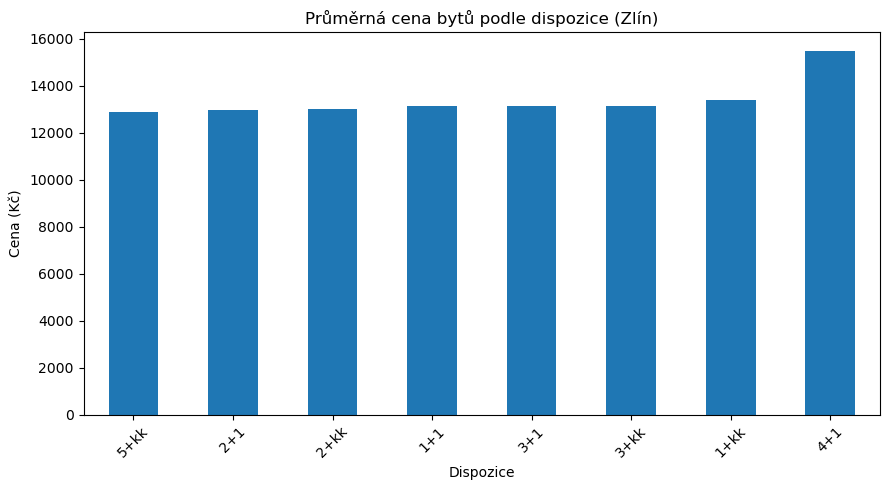

V lokalitě Zlín jsou ceny pronájmu bytů dle různých dispozic vyrovnané, výjimkou je dispozice 4+1, který se pronajímá za vyšší cenu


In [105]:
plt.figure(figsize=(9,5))
cena_dispozice.plot(kind="bar")
plt.title("Průměrná cena bytů podle dispozice (Zlín)")
plt.xlabel("Dispozice")
plt.ylabel("Cena (Kč)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'V lokalitě Zlín jsou ceny pronájmu bytů dle různých dispozic vyrovnané, výjimkou je dispozice 4+1, který se pronajímá za vyšší cenu')

= průměrná velikost bytu podle dispozice, doplněno grafem

In [125]:
velikost_dispozice = (
    df.groupby("dispozice")["rozmera_m2"]
    .mean()
    .sort_values()
    
)


velikost_dispozice

dispozice
5+kk    35.000000
1+1     38.894737
3+1     39.055556
2+kk    39.300000
2+1     39.478261
3+kk    40.210526
1+kk    40.800000
4+1     51.333333
Name: rozmera_m2, dtype: float64

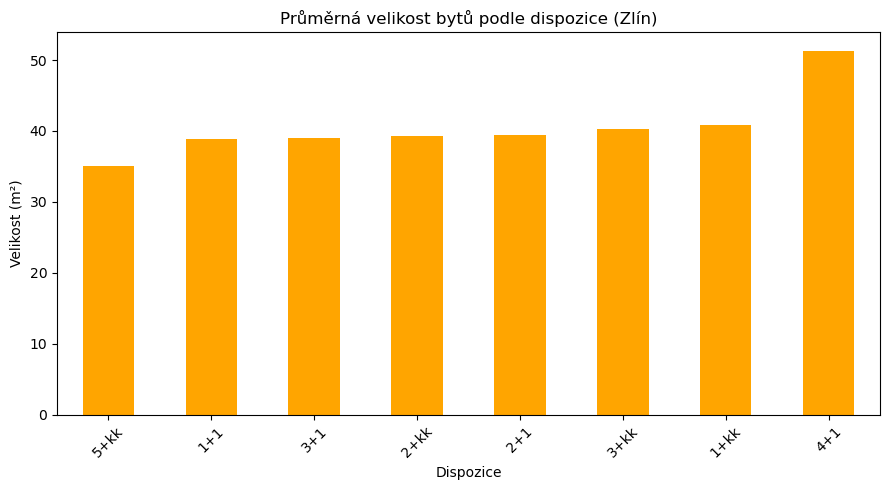

In [107]:
plt.figure(figsize=(9,5))
velikost_dispozice.plot(kind="bar", color="orange")
plt.title("Průměrná velikost bytů podle dispozice (Zlín)")
plt.xlabel("Dispozice")
plt.ylabel("Velikost (m²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

= průměrná cena dražších bytů - TOP 5 ulic

In [129]:
prumerna_cena = df["cena_kc"].mean()

drazsi = df[df["cena_kc"] > prumerna_cena]

top_ulice = (
    drazsi.groupby("ulice")["cena_kc"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

top_ulice

print(f' V některých ulicích se koncentrují dražší byty, což může souviset zejména s atraktivitou lokality, případně kvalitou zástavby')

 V některých ulicích se koncentrují dražší byty, což může souviset zejména s atraktivitou lokality, případně kvalitou zástavby


= nejčastější dispozice, doplněno grafem

In [130]:
nejcastejsi = df["dispozice"].value_counts()
nejcastejsi

dispozice
1+kk    35
2+kk    30
2+1     23
1+1     19
3+kk    19
3+1     18
4+1      3
5+kk     1
Name: count, dtype: int64

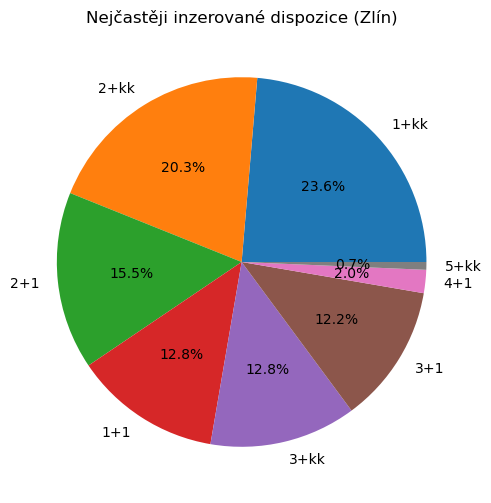

Nejčastěji inzerovaným pronájmem jsou byty o dispozici 1+1 a dále 2+kk.
Může to být dáno tím, že tyto byty jspu takzv investiční.
Dalším faktorem může být opuštění menších bytů stěhováním do větších bytů nebo rodinných domů.


In [133]:
plt.figure(figsize=(6,6))
nejcastejsi.plot(kind="pie", autopct="%1.1f%%")
plt.title("Nejčastěji inzerované dispozice (Zlín)")
plt.ylabel("")
plt.show()

print(f'Nejčastěji inzerovaným pronájmem jsou byty o dispozici 1+1 a dále 2+kk.')
print(f'Může to být dáno tím, že tyto byty jspu takzv investiční.')
print(f'Dalším faktorem může být opuštění menších bytů stěhováním do větších bytů nebo rodinných domů.')


= byty za nájemné vyšší než 20 000 kč

In [153]:
nad_20k = df[df["cena_kc"] > 20000]

nad_20k.shape



(0, 7)

In [154]:
nad_20k[["dispozice", "cena_kc", "rozmera_m2", "ulice", "mesto", "url"]].sort_values("cena_kc", ascending=False)


,dispozice,cena_kc,rozmera_m2,ulice,mesto,url


In [151]:
df["cena_kc"].max()

17000

In [ ]:
df.sort_values("cena_kc", ascending=False)[["dispozice","cena_kc","rozmera_m2","ulice","mesto","url"]].head(15)

print(f' V analyzovaném datasetu se inzeráty s pronájmem vyšším než 20 000 kč nevyskytují.')
print(f'maximální cena pronájmu byla nalezena pod 20 000 Kč')

,dispozice,cena_kc,rozmera_m2,ulice,mesto,url
51,3+kk,17000,60.0,Sýkory II,Zlín - Prštné,https://www.sreality.cz/detail/pronajem/byt/3+...
50,2+kk,17000,60.0,Lešetín I,Zlín,https://www.sreality.cz/detail/pronajem/byt/2+...
49,1+kk,17000,60.0,Lešetín I,Zlín,https://www.sreality.cz/detail/pronajem/byt/1+...
48,4+1,17000,60.0,Pod Vrškem,Zlín,https://www.sreality.cz/detail/pronajem/byt/4+...
36,2+kk,17000,60.0,Zahradní,Zlín - Malenovice,https://www.sreality.cz/detail/pronajem/byt/2+...
37,1+1,17000,60.0,Ševcovská,Zlín,https://www.sreality.cz/detail/pronajem/byt/1+...
38,1+kk,17000,60.0,Pod Hradem I,Zlín - Malenovice,https://www.sreality.cz/detail/pronajem/byt/1+...
39,3+kk,17000,60.0,Rašínova,Zlín,https://www.sreality.cz/detail/pronajem/byt/3+...
40,1+kk,17000,60.0,J. A. Bati,Zlín,https://www.sreality.cz/detail/pronajem/byt/1+...
41,3+1,17000,60.0,Mlýnská,Zlín - Malenovice,https://www.sreality.cz/detail/pronajem/byt/3+...


= min a max ceny podle dispozice, rozptyl cen

In [136]:
rozpeti = (
    df.groupby("dispozice")["cena_kc"]
    .agg(["min", "max"])
)

rozpeti["rozptyl"] = rozpeti["max"] - rozpeti["min"]
rozpeti

,min,max,rozptyl
dispozice,,,
1+1,11500,17000,5500
1+kk,11500,17000,5500
2+1,11500,17000,5500
2+kk,11500,17000,5500
3+1,11500,17000,5500
3+kk,11500,17000,5500
4+1,12500,17000,4500
5+kk,12900,12900,0


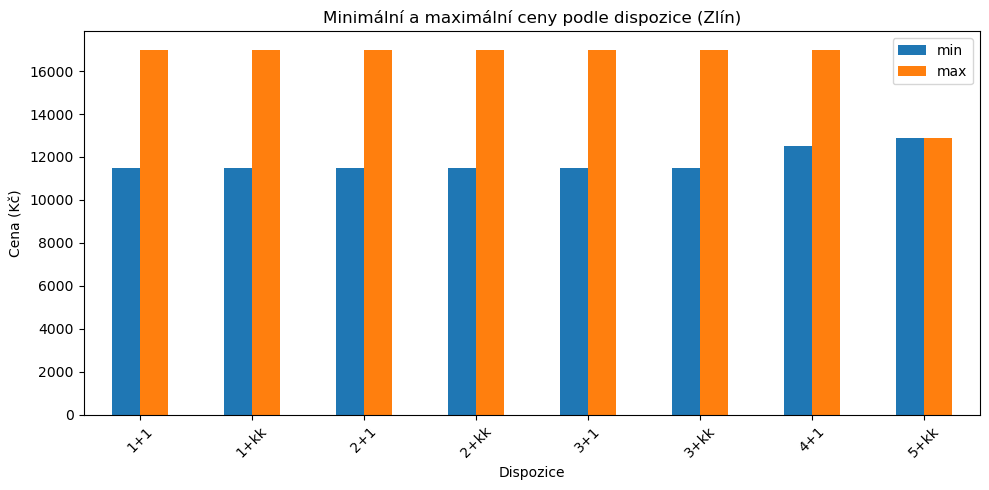

 Největší rozpětí min a max ceny mají dispozice menší, dispozice od 4+1 má rozpětí menší.


In [139]:
rozpeti[["min", "max"]].plot(kind="bar", figsize=(10,5))
plt.title("Minimální a maximální ceny podle dispozice (Zlín)")
plt.xlabel("Dispozice")
plt.ylabel("Cena (Kč)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f' Největší rozpětí min a max ceny mají dispozice menší, dispozice od 4+1 má rozpětí menší.')